## Sparklink demo 

In this demo we de-duplicate a small dataset.

The purpose is to provide an end-to-end example of how to use the package

I print the output at each stage using `spark_dataframe.show()`.  This is for instructional purposes only - it degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [2]:
import logging 
logging.basicConfig()

# Set to DEBUG if you want sparklink to log the SQL statements it's executing under the hood
logging.getLogger("sparklink").setLevel(logging.INFO)

In [3]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

conf=SparkConf()

# Load in a jar that provides extended string comparison functions such as Jaro Winkler.
# Sparklink 
conf.set('spark.driver.extraClassPath', 'jars/scala-udf-similarity-0.0.6.jar')
conf.set('spark.jars', 'jars/scala-udf-similarity-0.0.6.jar')   


# WARNING:
# These config options are appropriate only if you're running Spark locally!!!
conf.set('spark.driver.memory', '4g')
conf.set("spark.sql.shuffle.partitions", "8") 

sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession(sc)

 # Register UDFs
from pyspark.sql import types
spark.udf.registerJavaFunction('jaro_winkler_sim', 'uk.gov.moj.dash.linkage.JaroWinklerSimilarity', types.DoubleType())
spark.udf.registerJavaFunction('Dmetaphone', 'uk.gov.moj.dash.linkage.DoubleMetaphone', types.StringType())

## Step 2:  Configure sparklink using the `settings` object

Most of `sparklink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

Customisation overrides default values built into sparklink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/sparklink/blob/dev/sparklink/files/settings_jsonschema.json).  We also provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](https://robinlinacre.com/simple_sparklink_settings_editor/).



In [4]:
settings = {
    "proportion_of_matches": 0.5,
    "link_type": "dedupe_only",
    "blocking_rules": [
        'l.first_name = r.first_name',
        'l.surname = r.surname',
        'l.dob = r.dob'
    ],
    "comparison_columns": [
        {
            "col_name": "first_name",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city"
        },
        {
            "col_name": "email"
        }
    ]
    
}

In words, this setting dictionary says:
- We are performing a deduplication task (the other options are `link_only`, or `link_and_dedupe`)
- The initial value (prior belief) for the proportion of matches amongst comparisons is 0.5 (50% of comparisons that result from the blocking rules are matches).
- We are going generate comparisons subject to the blocking rules contained in the specified array
- When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `first_name` and `surname`, string comparisons will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match

## Step 3:  Read in data

In [5]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



## Step 4:  Estimate match scores using the Expectation Maximisation algorithm
Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.

In [6]:
from sparklink import Sparklink

linker = Sparklink(settings, spark, df=df)
df_e = linker.get_scored_comparisons()
df_e.persist()  # Later, we will make term frequency adjustments.  Persist caches these results in memory, preventing them having to be recomputed when we make these adjustments.

INFO:sparklink.iterate:
Iteration 0 complete

INFO:sparklink.iterate:
Iteration 1 complete

INFO:sparklink.iterate:
Iteration 2 complete

INFO:sparklink.iterate:
Iteration 3 complete

INFO:sparklink.iterate:
Iteration 4 complete



DataFrame[match_probability: double, unique_id_l: bigint, unique_id_r: bigint, first_name_l: string, first_name_r: string, gamma_first_name: int, prob_gamma_first_name_non_match: double, prob_gamma_first_name_match: double, surname_l: string, surname_r: string, gamma_surname: int, prob_gamma_surname_non_match: double, prob_gamma_surname_match: double, dob_l: string, dob_r: string, gamma_dob: int, prob_gamma_dob_non_match: double, prob_gamma_dob_match: double, city_l: string, city_r: string, gamma_city: int, prob_gamma_city_non_match: double, prob_gamma_city_match: double, email_l: string, email_r: string, gamma_email: int, prob_gamma_email_non_match: double, prob_gamma_email_match: double]

## Step 5: Inspect results 



In [7]:
# Inspect main dataframe that contains the match scores
df_e.toPandas().sample(5)

,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,prob_gamma_first_name_non_match,prob_gamma_first_name_match,surname_l,surname_r,gamma_surname,prob_gamma_surname_non_match,prob_gamma_surname_match,dob_l,dob_r,gamma_dob,prob_gamma_dob_non_match,prob_gamma_dob_match,city_l,city_r,gamma_city,prob_gamma_city_non_match,prob_gamma_city_match,email_l,email_r,gamma_email,prob_gamma_email_non_match,prob_gamma_email_match
5060,0.507504,277,278,Jackson,Lily,0,0.506817,0.436391,Lily,Jackson,0,0.320595,0.430802,2000-07-30,2000-07-30,1,0.047471,0.81194,Mansfield,Mlnsfied,0,0.848251,0.285577,lewischristopher@black-thomas.net,lewischristophr@black-thomas.net,0,0.979582,0.267439
3624,0.006382,310,419,Isabelle,Emily,0,0.506817,0.436391,Brown,Brown,2,0.677148,0.491347,1979-01-22,2005-07-15,0,0.952529,0.18806,Stoke-on-Trent,Lndon,0,0.848251,0.285577,josephwatson@smith.com,sarahbrown@mckinney.com,0,0.979582,0.267439
3481,0.744366,263,264,Flcrnoe,None,-1,1.000000,1.000000,Morris,Morris,2,0.677148,0.491347,1993-01-29,1993-03-31,0,0.952529,0.18806,None,Southampton,-1,1.000000,1.000000,paul49@allen.biz,paul49@allen.biz,1,0.020418,0.732561
4006,0.007404,463,971,Isaac,None,-1,1.000000,1.000000,Taylor,Taylor,2,0.677148,0.491347,2008-09-09,1978-05-09,0,0.952529,0.18806,Swndon,Ldnon,0,0.848251,0.285577,xday@higgins-lewis.com,tiffanyrodriguez@rodriguez-yu.com,0,0.979582,0.267439
5608,0.992670,888,893,Mila,Hall,0,0.506817,0.436391,Hall,Mila,0,0.320595,0.430802,2007-10-30,2007-10-30,1,0.047471,0.81194,Bimingram,Birmingham,0,0.848251,0.285577,stephanieromero@smith.com,stephanieromero@smith.com,1,0.020418,0.732561


The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

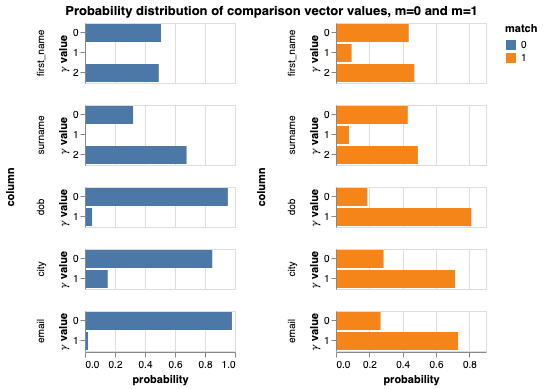

In [8]:
params = linker.params
params.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

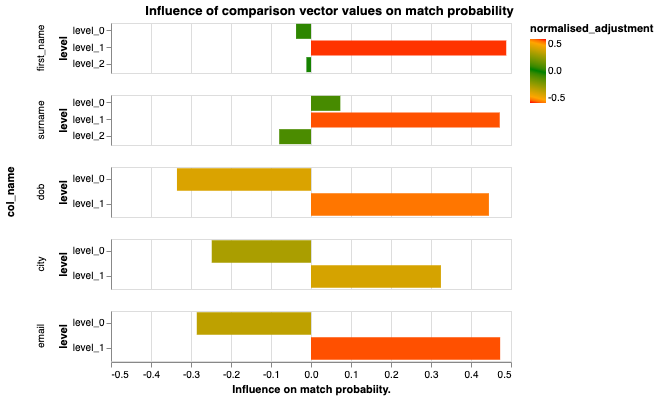

In [9]:
params.adjustment_factor_chart()

In [10]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default sparklink_charts.html)
params.all_charts_write_html_file()

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [11]:
from sparklink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, params))


Initial probability of match (prior) = λ = 0.361642986536026

Comparison of first_name.  Values are:
first_name_l: Mohammed 
first_name_r: Moh medm
Comparison has 3 levels
𝛾 for this comparison = gamma_first_name = 0
Amongst matches, P(𝛾 = 0.43639060854911804):
Amongst non matches, P(𝛾 = 0.5068172812461853):
Adjustment factor = p1/(p1 + p2) = 0.46266641031154254
New probability of match (updated belief): 0.3278659371925258

Comparison of surname.  Values are:
surname_l: Patel
surname_r: Patel
Comparison has 3 levels
𝛾 for this comparison = gamma_surname = 2
Amongst matches, P(𝛾 = 0.49134692549705505):
Amongst non matches, P(𝛾 = 0.6771483421325684):
Adjustment factor = p1/(p1 + p2) = 0.42049543469165057
New probability of match (updated belief): 0.26142157825161716

Comparison of dob.  Values are:
dob_l: 1989-03-19
dob_r: 1989-03-19
Comparison has 2 levels
𝛾 for this comparison = gamma_dob = 1
Amongst matches, P(𝛾 = 0.8119403123855591):
Amongst non matches, P(𝛾 = 0.04747146740555763):


## Step 7: Term frequency adjustments

Sparklink enables you to make adjustments for term frequency on any number of columns

This enables match probabilities to be adjusted for e.g. the fact John Smith is more prevalent than Robin Linacre

In [12]:
df_e_adj = linker.make_term_frequency_adjustments(df_e)


    select
        
    cast(match_probability as double) * cast(first_name_adj as double) * cast(surname_adj as double)/
    (  cast(match_probability as double) * cast(first_name_adj as double) * cast(surname_adj as double) + (cast(1 - cast(match_probability as double) as double)) * (cast(1 - cast(first_name_adj as double) as double)) * (cast(1 - cast(surname_adj as double) as double)) )
     as tf_adjusted_match_prob,
        match_probability,
        unique_id_l, unique_id_r, first_name_l, first_name_r, gamma_first_name, prob_gamma_first_name_non_match, prob_gamma_first_name_match, first_name_adj, surname_l, surname_r, gamma_surname, prob_gamma_surname_non_match, prob_gamma_surname_match, surname_adj, dob_l, dob_r, gamma_dob, prob_gamma_dob_non_match, prob_gamma_dob_match, city_l, city_r, gamma_city, prob_gamma_city_non_match, prob_gamma_city_match, email_l, email_r, gamma_email, prob_gamma_email_non_match, prob_gamma_email_match

    from df_e_adj
    


In [13]:
pdtf = df_e_adj.toPandas()
sam = pdtf.sample(10)
sam[["match_probability", "tf_adjusted_match_prob"] + list(pdtf.columns)]

,match_probability,tf_adjusted_match_prob,tf_adjusted_match_prob,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,prob_gamma_first_name_non_match,prob_gamma_first_name_match,first_name_adj,surname_l,surname_r,gamma_surname,prob_gamma_surname_non_match,prob_gamma_surname_match,surname_adj,dob_l,dob_r,gamma_dob,prob_gamma_dob_non_match,prob_gamma_dob_match,city_l,city_r,gamma_city,prob_gamma_city_non_match,prob_gamma_city_match,email_l,email_r,gamma_email,prob_gamma_email_non_match,prob_gamma_email_match
858,0.013021,0.003063,0.003063,0.013021,311,873,Harrison,Harrison,2,0.492055,0.469895,0.188917,obsGn,Cole,0,0.320595,0.430802,0.500000,2005-04-24,2017-09-16,0,0.952529,0.18806,Lnodn,Bristol,0,0.848251,0.285577,elizabeth81@smith.com,sheltenshannon@mndoz.com,0,0.979582,0.267439
3594,0.007404,0.002821,0.002821,0.007404,308,423,Isabelle,None,-1,1.000000,1.000000,0.500000,Brown,Brown,2,0.677148,0.491347,0.274953,1979-01-22,2005-07-15,0,0.952529,0.18806,Stoke-on-Trent,London,0,0.848251,0.285577,josephwatson@smith.com,sarahbron@mckinney.com,0,0.979582,0.267439
310,0.013021,0.004119,0.004119,0.013021,105,152,Harry,Harry,2,0.492055,0.469895,0.238664,Tomas,Hill,0,0.320595,0.430802,0.500000,2011-07-30,2017-10-23,0,0.952529,0.18806,Belast,Sheffield,0,0.848251,0.285577,sandra26@anderson-davis.com,zporter@robinson.com,0,0.979582,0.267439
1647,0.960386,0.929788,0.929788,0.960386,606,611,Ivy,Ivy,2,0.492055,0.469895,0.353265,Kay,Ky,0,0.320595,0.430802,0.500000,1996-04-18,1996-01-13,0,0.952529,0.18806,Peterborough,Peterborough,1,0.151749,0.714423,seancollins@dean.com,seancollins@dean.com,1,0.020418,0.732561
1596,0.267337,0.659469,0.659469,0.267337,596,597,Maisie,Maisie,2,0.492055,0.469895,0.840238,Foster,Foster,2,0.677148,0.491347,0.502277,2001-05-29,2001-08-30,0,0.952529,0.18806,London,London,1,0.151749,0.714423,hhill@paul-day.org,None,-1,1.000000,1.000000
4906,0.790551,0.790551,0.790551,0.790551,101,102,Morris,Noah,0,0.506817,0.436391,0.500000,Noah,Morris,0,0.320595,0.430802,0.500000,1983-07-20,1983-07-20,1,0.047471,0.81194,Birmngham,Birmingham,0,0.848251,0.285577,None,emilysmith@irwin-medina.biz,-1,1.000000,1.000000
3429,0.018721,0.001866,0.001866,0.018721,240,598,Turner,King,0,0.506817,0.436391,0.500000,Ryan,Ryan,2,0.677148,0.491347,0.089253,1990-06-04,1982-06-22,0,0.952529,0.18806,London,None,-1,1.000000,1.000000,onorman@walker.info,cervantesjasmine@cole.net,0,0.979582,0.267439
3917,0.006382,0.002430,0.002430,0.006382,421,522,Eimy,Mrt ah,0,0.506817,0.436391,0.500000,Brown,Brown,2,0.677148,0.491347,0.274953,2005-05-02,2002-09-01,0,0.952529,0.18806,London,Southend-on-Sea,0,0.848251,0.285577,sarahbrown@mckinney.com,watsonth@masojones-stuart.iz,0,0.979582,0.267439
1293,0.013021,0.005743,0.005743,0.013021,475,554,Henry,Henry,2,0.492055,0.469895,0.304522,Ali,Owen,0,0.320595,0.430802,0.500000,2012-11-30,2016-03-06,0,0.952529,0.18806,Newctsale-pon-Tyne,Kingston-upon-Hull,0,0.848251,0.285577,laura12@nelson.com,nicholasbutler@jackson.net,0,0.979582,0.267439
806,0.929034,0.999268,0.999268,0.929034,281,285,Jackson,Jackson,2,0.492055,0.469895,0.756520,Sara,Sara,2,0.677148,0.491347,0.971082,1999-09-18,1999-12-18,0,0.952529,0.18806,Liverpool,Liverpool,1,0.151749,0.714423,kimashley@nguyen.info,kimashley@nguyen.info,1,0.020418,0.732561


In [14]:
sam

,tf_adjusted_match_prob,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,prob_gamma_first_name_non_match,prob_gamma_first_name_match,first_name_adj,surname_l,surname_r,gamma_surname,prob_gamma_surname_non_match,prob_gamma_surname_match,surname_adj,dob_l,dob_r,gamma_dob,prob_gamma_dob_non_match,prob_gamma_dob_match,city_l,city_r,gamma_city,prob_gamma_city_non_match,prob_gamma_city_match,email_l,email_r,gamma_email,prob_gamma_email_non_match,prob_gamma_email_match
858,0.003063,0.013021,311,873,Harrison,Harrison,2,0.492055,0.469895,0.188917,obsGn,Cole,0,0.320595,0.430802,0.500000,2005-04-24,2017-09-16,0,0.952529,0.18806,Lnodn,Bristol,0,0.848251,0.285577,elizabeth81@smith.com,sheltenshannon@mndoz.com,0,0.979582,0.267439
3594,0.002821,0.007404,308,423,Isabelle,None,-1,1.000000,1.000000,0.500000,Brown,Brown,2,0.677148,0.491347,0.274953,1979-01-22,2005-07-15,0,0.952529,0.18806,Stoke-on-Trent,London,0,0.848251,0.285577,josephwatson@smith.com,sarahbron@mckinney.com,0,0.979582,0.267439
310,0.004119,0.013021,105,152,Harry,Harry,2,0.492055,0.469895,0.238664,Tomas,Hill,0,0.320595,0.430802,0.500000,2011-07-30,2017-10-23,0,0.952529,0.18806,Belast,Sheffield,0,0.848251,0.285577,sandra26@anderson-davis.com,zporter@robinson.com,0,0.979582,0.267439
1647,0.929788,0.960386,606,611,Ivy,Ivy,2,0.492055,0.469895,0.353265,Kay,Ky,0,0.320595,0.430802,0.500000,1996-04-18,1996-01-13,0,0.952529,0.18806,Peterborough,Peterborough,1,0.151749,0.714423,seancollins@dean.com,seancollins@dean.com,1,0.020418,0.732561
1596,0.659469,0.267337,596,597,Maisie,Maisie,2,0.492055,0.469895,0.840238,Foster,Foster,2,0.677148,0.491347,0.502277,2001-05-29,2001-08-30,0,0.952529,0.18806,London,London,1,0.151749,0.714423,hhill@paul-day.org,None,-1,1.000000,1.000000
4906,0.790551,0.790551,101,102,Morris,Noah,0,0.506817,0.436391,0.500000,Noah,Morris,0,0.320595,0.430802,0.500000,1983-07-20,1983-07-20,1,0.047471,0.81194,Birmngham,Birmingham,0,0.848251,0.285577,None,emilysmith@irwin-medina.biz,-1,1.000000,1.000000
3429,0.001866,0.018721,240,598,Turner,King,0,0.506817,0.436391,0.500000,Ryan,Ryan,2,0.677148,0.491347,0.089253,1990-06-04,1982-06-22,0,0.952529,0.18806,London,None,-1,1.000000,1.000000,onorman@walker.info,cervantesjasmine@cole.net,0,0.979582,0.267439
3917,0.002430,0.006382,421,522,Eimy,Mrt ah,0,0.506817,0.436391,0.500000,Brown,Brown,2,0.677148,0.491347,0.274953,2005-05-02,2002-09-01,0,0.952529,0.18806,London,Southend-on-Sea,0,0.848251,0.285577,sarahbrown@mckinney.com,watsonth@masojones-stuart.iz,0,0.979582,0.267439
1293,0.005743,0.013021,475,554,Henry,Henry,2,0.492055,0.469895,0.304522,Ali,Owen,0,0.320595,0.430802,0.500000,2012-11-30,2016-03-06,0,0.952529,0.18806,Newctsale-pon-Tyne,Kingston-upon-Hull,0,0.848251,0.285577,laura12@nelson.com,nicholasbutler@jackson.net,0,0.979582,0.267439
806,0.999268,0.929034,281,285,Jackson,Jackson,2,0.492055,0.469895,0.756520,Sara,Sara,2,0.677148,0.491347,0.971082,1999-09-18,1999-12-18,0,0.952529,0.18806,Liverpool,Liverpool,1,0.151749,0.714423,kimashley@nguyen.info,kimashley@nguyen.info,1,0.020418,0.732561
